Copyright (C) Egon Kidmose 2015-2017

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from datetime import timedelta
import os
import re

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load data ##

In [2]:
# Verify existing
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; find  -iname '*.md5' -print0 | sort -z | xargs -0 -n1 bash -c 'cat ${0}; md5sum --check ${0}'
# extract
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; unzip -o CSVs.zip -d CSVs
# checksum extracted CSVs
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *
# pandas can't parse u"Infinity" as a float. Replacing with u"inf". https://github.com/pandas-dev/pandas/issues/10065
!sed -i'' 's/,Infinity,/,Inf,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove spaces leading fields
!sed -i'' 's/, /,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove rows with fields empty
!sed -i'' '/^,\{84\}\s\?$/d' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# checksum extracted CSVs, with above changes
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *

da341068fd24fe4affa5a6995808ceb5  CSVs.zip
CSVs.zip: OK
7366c552425956e610bd69f57feb7e7a  Friday-WorkingHours.pcap
Friday-WorkingHours.pcap: OK
8525733283c2c5f98891a0dca036e7c7  Monday-WorkingHours.pcap
Monday-WorkingHours.pcap: OK
043d37cd08de4e165a5498d0d6564a65  Thursday-WorkingHours.pcap
Thursday-WorkingHours.pcap: OK
2d976fec5b8b3676c1c4152a9195bba7  Tuesday-WorkingHours.pcap
Tuesday-WorkingHours.pcap: OK
a8c9cd0ea22e3df6acc1c5972f38f0bf  Wednesday-workingHours.pcap
Wednesday-workingHours.pcap: OK
Archive:  CSVs.zip
  inflating: CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: CSVs/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: CSVs/Tuesday-WorkingHours.pcap_ISCX.csv  
  inf

In [3]:
data = pd.DataFrame()

for f in glob.glob('../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv'):
    print(u"Loading %s .." % f)
    df = pd.read_csv(
        f,
        dtype={
            'External IP': 'S15',
        },
        usecols=[
            'Flow ID',
            'Source IP',
            'Source Port',
            'Destination IP',
            'Destination Port',
            'Protocol',
            'Timestamp',
            'Flow Duration',
            'Label',
            'Total Fwd Packets',
            'Total Backward Packets',
        ],
        encoding='cp1252',
    )
    print(df.shape)
    df['File'] = os.path.basename(f)
    data = pd.concat([data, df])

Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv ..
(191033, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Monday-WorkingHours.pcap_ISCX.csv ..
(529918, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv ..
(445909, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ..
(170366, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ..
(288602, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Wednesday-workingHours.pcap_ISCX.csv ..
(692703, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ..
(286467, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscx

In [4]:
# Parse timestamp
def strptime(s):
    """
    Parse timestamp, handling intermittent zero-padding and omission of seconds.
    """
    r = re.compile('^(?P<day>[0-9]{1,2})/(?P<month>[0-9]{1,2})/(?P<year>[0-9]{4}) (?P<hour>[0-9]{1,2}):(?P<minute>[0-9]{2})(?::(?P<second>[0-9]{2}))?(?P<remainder>.+)?$')
    m = r.match(s)
    if m is None:
        raise ValueError('No match on %s' % s)
    d = m.groupdict()
    if d['remainder'] is not None:
        raise ValueError('Remainder is not None for \'%s\': %s' % (s, str(d)))
    d.pop('remainder')
    if d['second'] is None:
        d.pop('second') # Seconds are optional
    return datetime(**{k: int(v) for k, v in d.items()})

assert strptime('7/7/2017 8:59') == datetime(2017, 7, 7, 8, 59) # No zeropad, no seconds
assert strptime('03/07/2017 08:55:58') == datetime(2017, 7, 3, 8, 55, 58) # Zeropad, seconds

data.Timestamp = data.Timestamp.map(strptime)

In [5]:
# Make Description
description = data[['File', 'Label']].drop_duplicates().set_index(['File', 'Label'], drop=False).apply(
    lambda r: "%s (%s)" % (
        r[0].lower().replace('-workinghours', '').replace('.pcap_iscx.csv', ''), 
        r[1]
    ),
    axis=1
).rename('Description')
data = data.set_index(['File', 'Label']).join(description).reset_index()

In [6]:
# Parse Flow duration 
# By comparing 192.168.10.15:52772 <-> 1.1.70.73:80 TCP from pcap and csv => unit is microseconds
data['Flow Duration'] = data['Flow Duration'].map(
    lambda i: timedelta(seconds=float(i)/1e6)
)

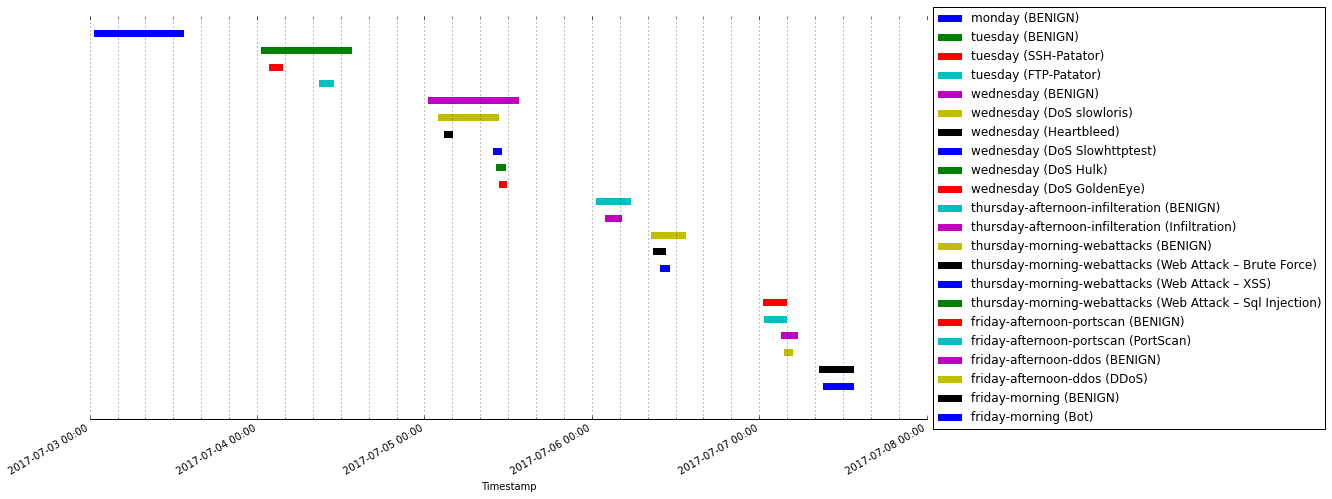

In [7]:
# Incident/series timespan plot

begin = data.groupby('Description').Timestamp.min().sort_values()
end = data.groupby('Description').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    legend=True,
    figsize=(15, 8),
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
ax.grid(which='minor')
ax.set_xlim([
    np.datetime64(begin.min(), 'D'),
    np.datetime64(end.max(), 'D') + np.timedelta64(1, 'D'),
])

ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

None

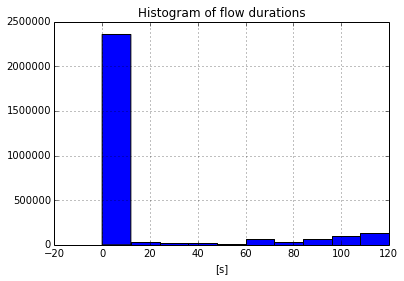

In [8]:
(data['Flow Duration'] / pd.Timedelta(seconds=1)).hist()
plt.title("Histogram of flow durations")
plt.xlabel("[s]")

In [9]:
begin[u'tuesday (FTP-Patator)']

Timestamp('2017-07-04 09:17:00')

In [10]:
end[u'tuesday (FTP-Patator)']

Timestamp('2017-07-04 10:30:00')